In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

In [2]:
#CONSTANT VALUES
IMAGE_SIZE = 256
EPOCH_NUM = 50

In [3]:
data = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
)

Found 55448 files belonging to 39 classes.


In [4]:
class_names = data.class_names
class_names


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

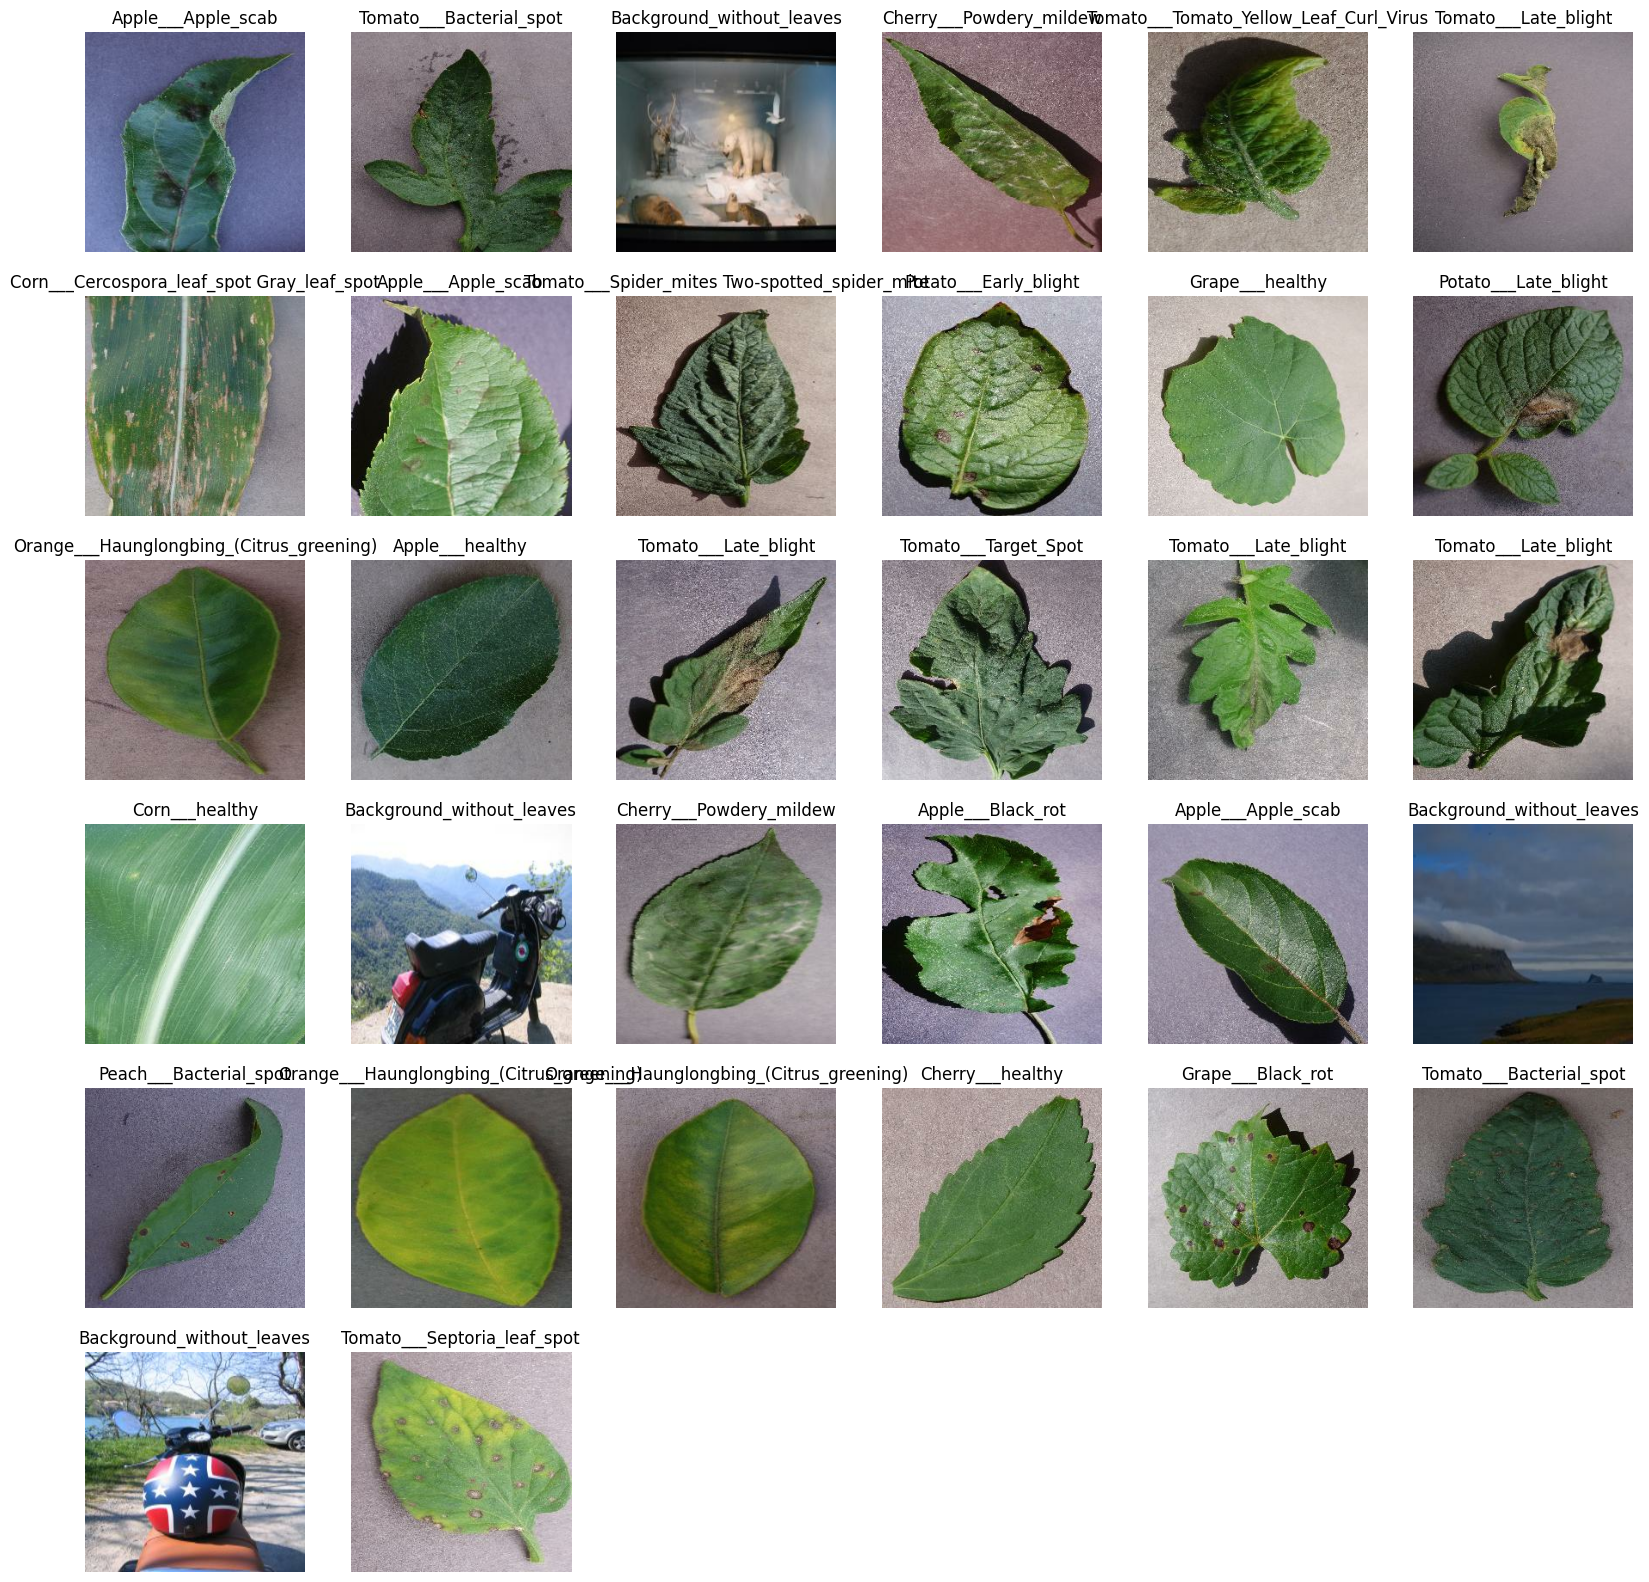

In [5]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in data.take(1):
    for i in range(32):
        plt.subplot(6,6, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

Train Test and Validate (80%, 10%, 10%)

In [6]:
ds_size = len(data)
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(data, ds_size)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCH_NUM
)

Epoch 1/10


1386/1386 [==============================] - 1110s 724ms/step - loss: 0.9559 - accuracy: 0.7271 - val_loss: 0.3111 - val_accuracy: 0.9027
Epoch 2/10
1386/1386 [==============================] - 998s 720ms/step - loss: 0.3155 - accuracy: 0.9012 - val_loss: 0.1930 - val_accuracy: 0.9449
Epoch 3/10
1386/1386 [==============================] - 1000s 721ms/step - loss: 0.1645 - accuracy: 0.9455 - val_loss: 0.1560 - val_accuracy: 0.9478
Epoch 4/10
1386/1386 [==============================] - 994s 718ms/step - loss: 0.1080 - accuracy: 0.9644 - val_loss: 0.0377 - val_accuracy: 0.9887
Epoch 5/10
1386/1386 [==============================] - 995s 718ms/step - loss: 0.0760 - accuracy: 0.9747 - val_loss: 0.0732 - val_accuracy: 0.9756
Epoch 6/10
1386/1386 [==============================] - 994s 717ms/step - loss: 0.0573 - accuracy: 0.9807 - val_loss: 0.0536 - val_accuracy: 0.9847
Epoch 7/10
1386/1386 [==============================] - 994s 717ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.0

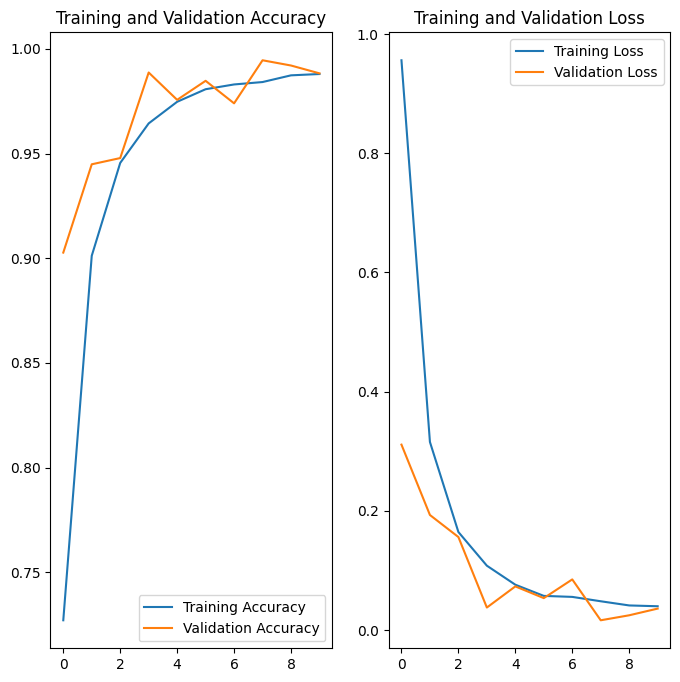

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH_NUM)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 186ms/step
predicted label: Potato___healthy


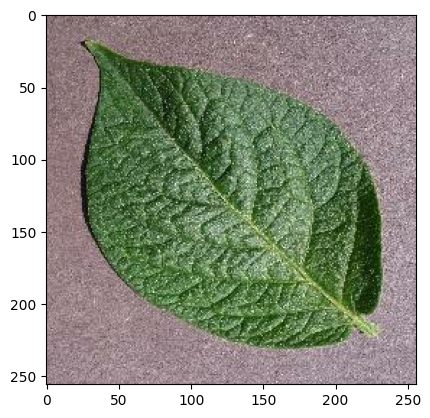

In [100]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [133]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = tf.nn.softmax(predictions[0])
    return predicted_class, confidence

In [134]:
def preprocess_image(image):
    # Resize the image to the model's input size
    image = tf.image.resize(image, (256, 256))
    # Normalize the pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

1/1 [==============================] - 0s 25ms/step


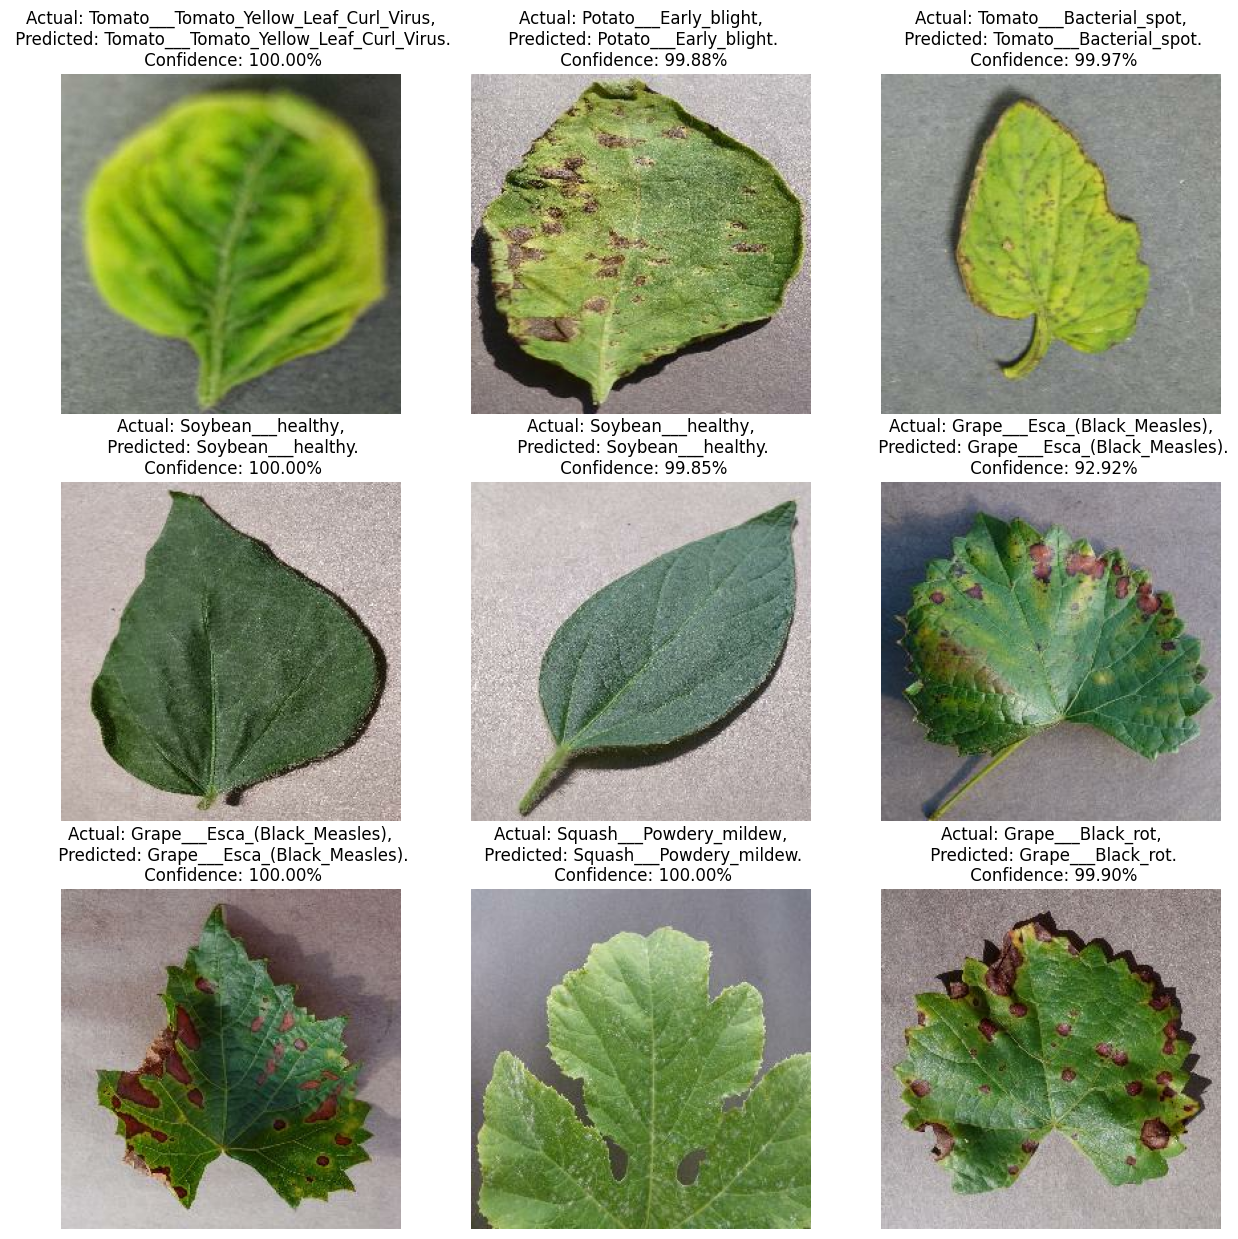

In [142]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = preprocess_image(images[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {100 * confidence[np.argmax(confidence)]:.2f}%")
        
        plt.axis("off")

In [ ]:
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./models/1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

In [ ]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

In [ ]:
for image, label in test_ds.unbatch().take(5):
    interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

In [ ]:
predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

In [ ]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

In [ ]:
np.array([True,False,True]).mean()

In [ ]:
accuracy = comparison_vector.mean()
accuracy